In [ ]:
from IPython.display import clear_output

In [ ]:
!echo "Downloading 101_Object_Categories for image notebooks"

!curl -L -o 101_ObjectCategories.zip --progress-bar https://data.caltech.edu/records/mzrjq-6wc02/files/caltech-101.zip?download=1
!unzip 101_ObjectCategories.zip
!mv caltech-101/101_ObjectCategories.tar.gz ./101_ObjectCategories.tar.gz
!tar -xzf 101_ObjectCategories.tar.gz
!rm 101_ObjectCategories.tar.gz
!ls

clear_output()

In [ ]:
import random

import torch
from torch.utils.data import Subset

import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),  # hint: Is something missing?
])

image_dataset = torchvision.datasets.ImageFolder(root='101_ObjectCategories', transform=transform)

In [ ]:
print(len(image_dataset))

9144


label=0


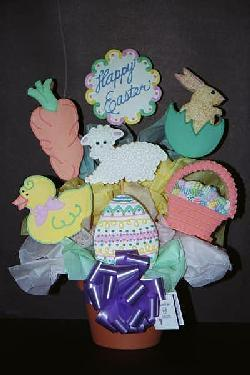

In [ ]:
img, label = image_dataset[50]
print(f'{label=}')
transforms.functional.to_pil_image(img)

# Tasks:

1. Download pretrained Resnet18 model from torchhub
2. Modify the model for object 101 dataset subset (The dataset has 101 distinct classes).
3. Split the dataset between training and validation set (80% / 20%).
4. Fine tune the model for classification on the dataset.
5. Output the fine tuned model's overall accuracy on the validation set.
6. Find a way to show label wise performance/accuracy of the finetuned model.